In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import genpareto, genextreme
from scipy.optimize import minimize
from scipy.special import gamma
import os

df = pd.read_csv('USW00094847.csv',parse_dates=["DATE"])
df = df[["DATE", "PRCP"]].dropna()
# Convert precipitation to millimeters
df["PRCP"] /= 10
# Use this threshold for calculating exceedances
thresh = 5.0
# Median annual maximum
df["year"] = df["DATE"].dt.year
annmax = np.median(df.groupby("year")["PRCP"].agg(np.max))
df

/var/folders/81/fr266crd1kq7t91jpmw9n7qm0000gn/T/ipykernel_34771/4076973259.py:10: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,49,51,53,55,57,59,61,63,65,67,69,71,85,91,93,95,97,99,101,103,105,107,109,111,113,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('USW00094847.csv',parse_dates=["DATE"])


,DATE,PRCP,year
1515,1958-12-01,0.0,1958
1516,1958-12-02,0.0,1958
1517,1958-12-03,0.0,1958
1518,1958-12-04,0.0,1958
1519,1958-12-05,1.3,1958
...,...,...,...
25175,2023-09-11,0.3,2023
25176,2023-09-12,5.3,2023
25177,2023-09-13,0.0,2023
25178,2023-09-14,0.0,2023


In [20]:
def fit_gev(x):
    x = np.sort(x)
    n = len(x)
    # The first three probability weighted moments
    b = np.zeros(3)
    pp = np.arange(1, n + 1) / (n + 1)
    for r in range(3):
        b[r] = np.dot(pp**r, x) / n
    # The PWM estimator of Hoskins et al.
    c = (2*b[1] - b[0]) / (3*b[2] - b[0])  - np.log(2) / np.log(3)
    shape = 7.8590*c + 2.9554*c**2
    scale = (2*b[1] - b[0]) * shape / (gamma(1 + shape) * (1 - 1/2**shape))
    loc = b[0] + scale*(gamma(1 + shape) - 1) / shape
    # Get the MLE
    x0 = np.asarray([shape, loc, scale])
    def f(par):
        shape, loc, scale = par
        d = genextreme(shape, loc=loc, scale=scale)
        return -d.logpdf(x).sum()
    rr = minimize(f, x0, method="powell")
    shape, loc, scale = rr.x
    return genextreme(shape, loc=loc, scale=scale)

In [21]:
def block_max(dx):
    # Get the annual maximum for all complete years
    dx = dx.query("year > 1958 & year < 2023")
    yrmx = dx.groupby("year")["PRCP"].agg(np.max)
    # Fit a generalized extreme value distribution to the block maxima.
    gev = fit_gev(yrmx)
    # m-observation returns
    rr = pd.DataFrame({"Years": [10, 100, 500, 1000]})
    rr["Return"] = gev.ppf(1 - 1/rr.Years)
    print("Returns based on GEV:")
    print(rr)
    # Make a QQ plot to assess goodness of fit
    z = np.sort(yrmx)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = gev.ppf(pp)
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.plot(qq, z)
    ax.set_xlabel("GEV quantiles")
    ax.set_ylabel("Order statistics")
    ax.set_title("GEV fit to annual maxima")
    pdf.savefig()
    return gev

In [22]:
def gp_estimate(z):
    z = np.sort(z)
    n = len(z)
    xstar = z[int(np.round(n/4 + 0.5))]
    m = np.ceil(20 + np.sqrt(n))
    xmax = z.max()
    jj = np.arange(1, m+1)
    tgrid = 1/xmax + (1 - np.sqrt(m/(jj-0.5))) / (3 * xstar)
    def profile(theta):
        k = -np.log(1 - theta*z).mean()
        return n*(np.log(theta/k) + k - 1)
    ltg = np.asarray([profile(t) for t in tgrid])
    ltg -= ltg.max()
    Ltg = np.exp(ltg)
    Ltg /= Ltg.sum()
    theta_hat = np.dot(Ltg, tgrid)
    k_hat = -np.log(1 - theta_hat*z).mean()
    scale_hat = k_hat / theta_hat
    return genpareto(-k_hat, scale=scale_hat)

In [23]:
def plot_hill(z):
    kv = np.arange(20, 501, 5)
    ta = np.asarray([hill(z, k=k) for k in kv])
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("Hill estimate of the tail index")
    ax.plot(kv, ta)
    ax.set_xlabel("k", size=16)
    ax.set_ylabel("Tail index estimate", size=16)
    pdf.savefig()

In [24]:
def eb_analysis(z):
    # Exceedances
    z = z[z > thresh] - thresh
    # Empirical Bayes estimate of Zhang and Stephens.
    eb = gp_estimate(z)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = eb.ppf(pp)
    z = np.sort(z)
    # QQ plot
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("EB: shape=%.3f scale=%.3f" % (eb.args[0], eb.kwds["scale"]))
    ax.plot(qq, z)
    plt.xlabel("GP quantiles (EB)", size=16)
    plt.ylabel("Order statistics", size=16)
    pdf.savefig()
    return eb

In [25]:
def tail_shape(z, p0=0.1, family="powerlaw"):
    if family not in ["exponential", "powerlaw"]:
        print("Unknown family $(family)")
        1/0
    p = 1 - p0
    z = np.asarray(z)
    z.sort()
    n = len(z)
    m = int(np.around(p*n))
    x = z[m-1:]
    if family == "powerlaw":
        x = np.log(x)
    p = np.log(1 - np.arange(m, n+1) / (n+1))
    return x, p

In [26]:
def fit_tail_reg(x, ax, p0=0.99, family="powerlaw"):
    x, p = tail_shape(x, p0=p0, family=family)
    ax.plot(x, p, color="orange")
    # Estimate the tail index using a least squares fit to the order
    # statistics.
    alpha_hat = -np.cov(p, x)[0, 1] / np.var(x)
    icept = p.mean() + alpha_hat*x.mean()
    # The coordinates of the best-fit line
    xx = np.asarray([x.min(), x.max()])
    yy = icept - alpha_hat*xx
    ax.plot(xx, yy, color="purple")
    return icept, alpha_hat

In [27]:
def plot_tails(z, p0, thresh, family):
    n = len(z)
    # Exceedances
    z = z[z >= thresh]
    z -= thresh
    # The number of selected observations
    m = int(np.around(p0*n))
    xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel("log(1-p)", size=16)
    ti = "%s model, threshold=%.1f, top %.1f%% (n=%d), alpha=%.3f" %\
           (family.title(), thresh, 100*p0, m, alpha)
    plt.title(ti)
    pdf.savefig()

In [28]:
# Estimate the tail index using Hill's estimator, based on
# the upper k order statistics.
def hill(z, k=200):
    z = np.sort(z)
    z = np.log(z)
    n = len(z)
    return 1 / (z[-k+1:] - z[-k]).mean()
def check_gp_estimate(shape, scale, thresh, n=100000):
    z = genpareto.rvs(shape, scale=scale, size=n)
    z = z[z > thresh] - thresh
    #shape_hill = hill(z)
    eb = gp_estimate(z)
    return eb#, shape_hill

In [29]:
#  Calculate the m-observation returns for the data in z, using either
# an exponential or generalized Pareto model.
def mobs_return(z, mr, thresh, family="exponential", gp=None):
    z = np.asarray(z)
    n = len(z)
    # Select only extreme values and translate back to the origin
    ix = np.flatnonzero(z >= thresh)
    q = len(ix) / n # proportion of values exceeding the threshold
    z = z[ix]
    z -= thresh
    pr = 1 - 1 / (q * mr)
    if family == "exponential":
        mn = z.mean()
        print("Mean = %.2f" % mn)
        m0 = thresh - mn*np.log(1 - pr)
    elif family == "generalizedpareto":
        print("Shape=%.2f" % eb.args[0])
        print("Scale=%.2f" % eb.kwds["scale"])
        m0 = thresh + gp.ppf(pr)
    else:
        error("!!")
    return m0

Returns based on GEV:
   Years      Return
0     10   77.339144
1    100  128.673047
2    500  180.129184
3   1000  207.682637


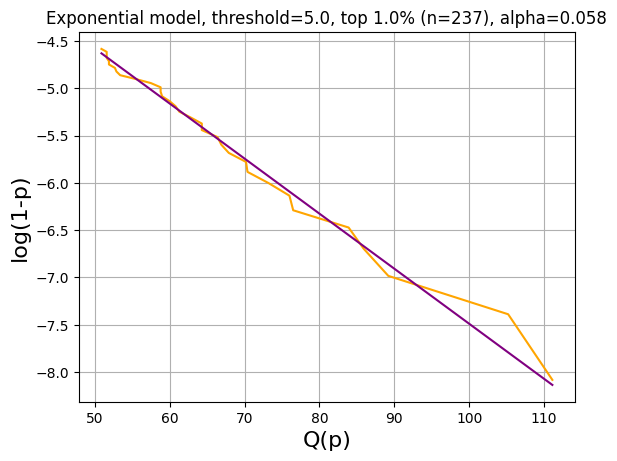

In [32]:
pdf = PdfPages("extremes_python.pdf")
target_dir = "desktop/umich/stats504"
gev = block_max(df)
# Quantile plots
for family in ["powerlaw", "exponential"]:
    for p0 in [0.5, 0.1, 0.05, 0.01]:
        plot_tails(df["PRCP"], p0, thresh, family)

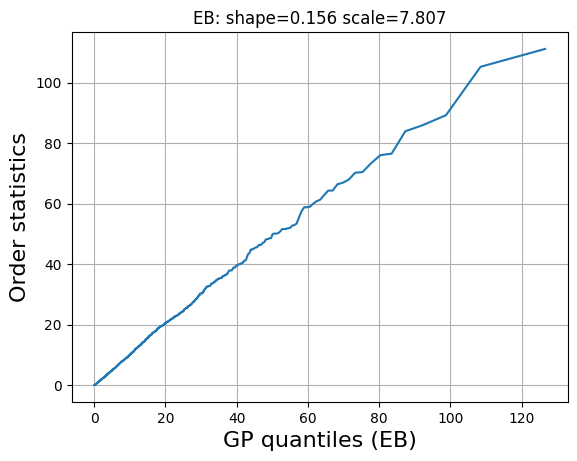

In [33]:
eb = eb_analysis(df["PRCP"])
eb

/var/folders/81/fr266crd1kq7t91jpmw9n7qm0000gn/T/ipykernel_34771/2962882197.py:5: RuntimeWarning: divide by zero encountered in log
  z = np.log(z)


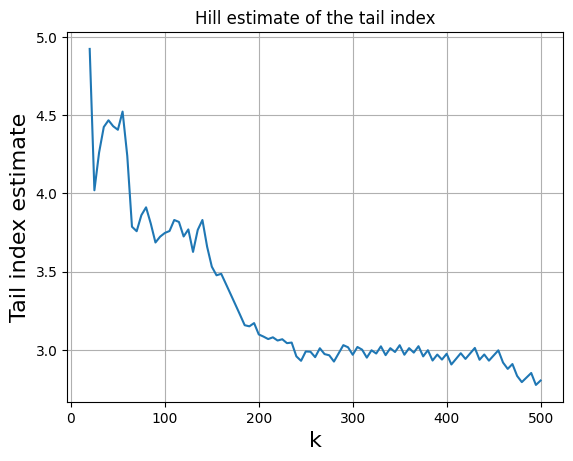

In [34]:
plot_hill(df["PRCP"])

In [35]:
yr = np.r_[1, 10, 100, 500, 1000]
cfg = [("exponential", None), ("generalizedpareto", eb)]
for (f,g) in cfg:
    print("\nReturns based on %s:" % f)
    mr = mobs_return(df["PRCP"], 365 * yr, thresh, family=f, gp=g)
    rr = pd.DataFrame({"Years": yr, "MR": mr})
    print(rr)


Returns based on exponential:
Mean = 9.23
   Years          MR
0      1   41.088754
1     10   62.345040
2    100   83.601326
3    500   98.458833
4   1000  104.857612

Returns based on generalizedpareto:
Shape=0.16
Scale=7.81
   Years          MR
0      1   47.059975
1     10   86.890483
2    100  143.953608
3    500  197.936739
4   1000  225.705016


In [36]:
pdf.close()